In [184]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression

In [150]:
pg_connection = psycopg2.connect(
    dbname="postgres",
    user="apparao",
    password="!bern@HARD23",
    host="thedb.postgres.database.azure.com",
    port="5432"
)

pg_cursor = pg_connection.cursor()

In [151]:
query_poll_votes_2020 = 'select * from pres_election.poll_votes_2020'

In [152]:
pg_cursor.execute(query_poll_votes_2020)
rows = pg_cursor.fetchall()

In [153]:
columns = [col[0] for col in pg_cursor.description]

In [154]:
columns

['cal_date',
 'polling_voting_delta',
 'swing_state',
 'state',
 'days_to_election',
 'month_of_poll',
 'swing_state_False',
 'swing_state_True',
 'votes_delta_jb']

In [155]:
poll_votes_2020 = pd.DataFrame(rows, columns=columns)

In [180]:
poll_votes_2020
poll_votes_2020 = poll_votes_2020.drop('cal_date', axis=1)

In [181]:

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(['bool','object']):
        X[colname], _ = X[colname].factorize()
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores   

    
    # mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    # mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
    # mi_scores = mi_scores.sort_values(ascending=False)
    # return mi_scores 

In [198]:
X = poll_votes_2020.copy()
y = X.pop('votes_delta_jb')
mi_scores =  make_mi_scores(X,y)

In [199]:
print(mi_scores)

state                   3.933080
polling_voting_delta    3.470184
swing_state             0.617550
swing_state_False       0.074587
swing_state_True        0.073786
month_of_poll           0.056245
days_to_election        0.000000
Name: MI Scores, dtype: float64


In [200]:
plt.figure(figsize=(15,8))

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

<Axes: xlabel='votes_delta_jb', ylabel='Count'>

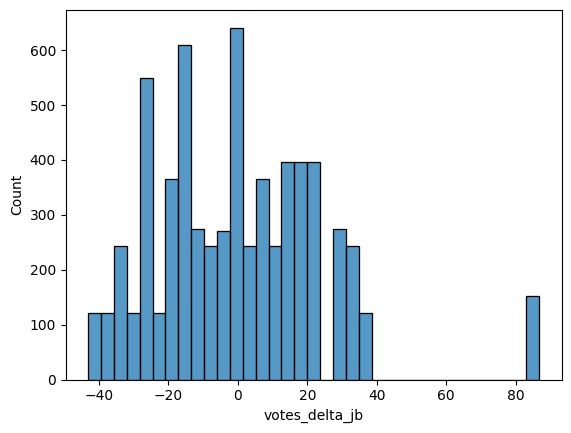

In [201]:
sns.histplot(y)

<Axes: xlabel='votes_delta_jb', ylabel='Count'>

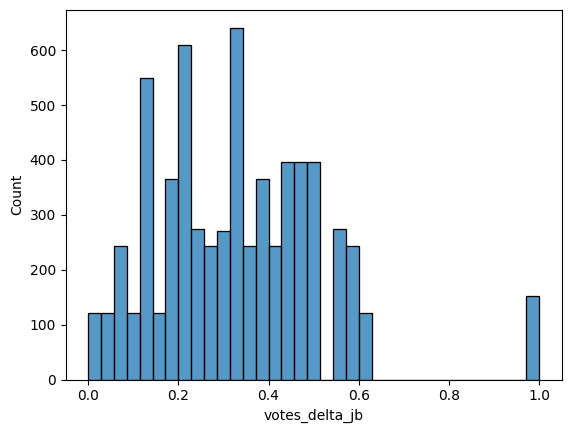

In [205]:
y_normalized = (y - y.min()) / (y.max() - y.min())
sns.histplot(y_normalized)

<Axes: ylabel='MI Scores'>

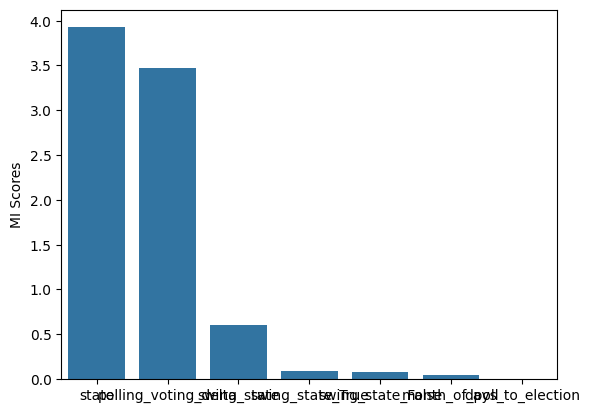

In [207]:
mi_scores_y_normalized =  make_mi_scores(X,y_normalized)
sns.barplot(mi_scores_y_normalized)

In [211]:
poll_votes_2020.loc[poll_votes_2020.votes_delta_jb != poll_votes_2020.votes_delta_jb.max()]
poll_votes_2020_no_dc = poll_votes_2020.loc[poll_votes_2020.votes_delta_jb != poll_votes_2020.votes_delta_jb.max()]

In [214]:
X = poll_votes_2020_no_dc.copy()
y = X.pop('votes_delta_jb')
mi_scores =  make_mi_scores(X,y)

<Axes: ylabel='MI Scores'>

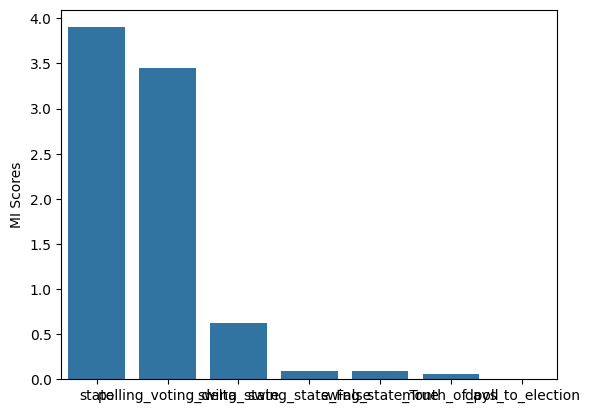

In [215]:
sns.barplot(mi_scores)

AttributeError: 'Series' object has no attribute 'flatten'

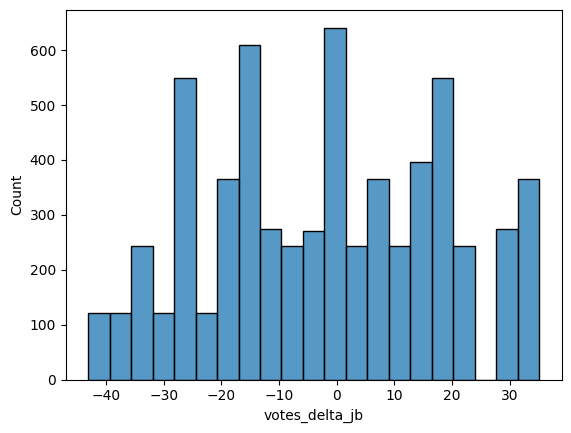

In [218]:
y_normalized = (y - y.min()) / (y.max() - y.min())
sns.histplot(y)
n = y_normalized.flatten()

In [ ]:
def score_model(X_train, y_train, X_val, y_val, model):
    model.fit(X_train, y_train)
    pred = model.predict